In [1]:
# Start by processing FMS (MOM6) and CICE6 results
from access.profiling import FMSProfilingParser, CICE5ProfilingParser
from access.profiling import PayuJSONProfilingParser
fmsparser = FMSProfilingParser(has_hits=True)
ciceparser = CICE5ProfilingParser()
payuparser = PayuJSONProfilingParser()

In [2]:
# Processing logs
from pathlib import Path
import glob

test_path = "/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3"
base_prefix = "mom6"
branch = "mom6_only"
count = 50
fmslogs = []
payulogs = []
for c in range(1, count+1):
    archive_dir = f"{test_path}/{base_prefix}_{c}/{branch}/archive"
    with open(archive_dir + "/output000/access-om3.out", "r") as f:
        fmslogs.append(f.read())

In [3]:
mom6_stats = fmsparser.parse_data_series(
    fmslogs,
    "ncpus",
    [52, 104, 156, 208, 260, 312, 364, 416, 468, 520, 572, 624, 676, 728, 780, 832, 884, 936, 988, 1040, 1092, 1144, 1196, 1248, 1300, 1352, 1404, 1456, 1508, 1560, 1612, 1664, 1716, 1768, 1820, 1872, 1924, 1976, 2028, 2080, 2132, 2184, 2236, 2288, 2340, 2392, 2444, 2496, 2548, 2600]
)
print(mom6_stats)

<xarray.Dataset> Size: 246kB
Dimensions:        (ncpus: 50, region: 66)
Coordinates:
  * ncpus          (ncpus) int64 400B 52 104 156 208 260 ... 2444 2496 2548 2600
  * region         (region) <U32 8kB 'Total runtime' ... '(Ocean forcing diag...
Data variables:
    count          (ncpus, region) int64 26kB [] 1 2 1 191 384 ... 24 0 383 215
    minimum time   (ncpus, region) float64 26kB [s] 2.54e+03 86.47 ... 0.09323
    maximum time   (ncpus, region) float64 26kB [s] 2.54e+03 86.48 ... 0.1568
    average time   (ncpus, region) float64 26kB [s] 2.54e+03 86.48 ... 0.1543
    time std       (ncpus, region) float64 26kB [s] 3e-06 0.004412 ... 0.001342
    time fraction  (ncpus, region) float64 26kB [%] 100.0 3.4 0.0 ... 0.8 0.0
    grain          (ncpus, region) int64 26kB [] 0 11 41 1 11 ... 41 31 31 11 41
    minimum PE     (ncpus, region) int64 26kB [] 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    maximum PE     (ncpus, region) int64 26kB [] 51 51 51 51 ... 2599 2599 2599


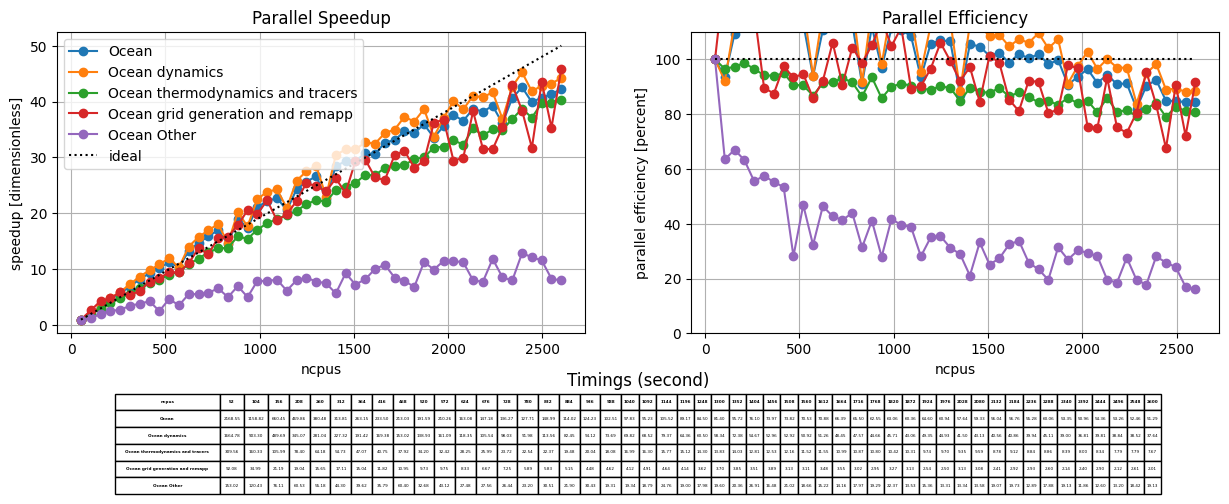

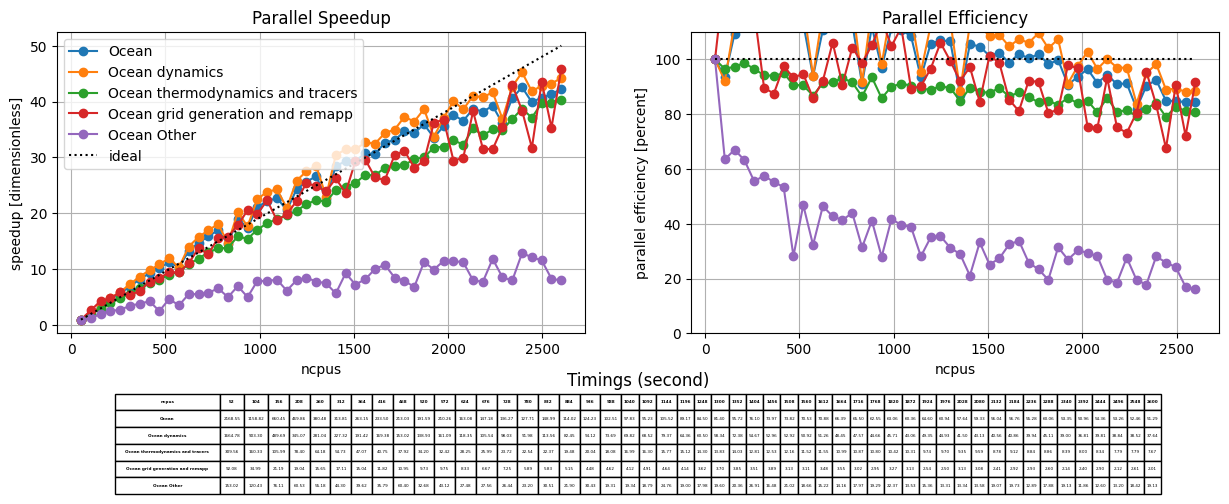

In [4]:
from access.profiling.scaling import plot_scaling_metrics
from access.profiling.metrics import tmax

# plots the Ocean region and tmax metric from the FMS stats, and 
# payu_model_run_duration_seconds region and walltime metric from payu stats.
plot_scaling_metrics(
    stats=[mom6_stats],
    # stats=[mom6_stats, payu_stats], 
    regions=[
        ["Ocean", "Ocean dynamics", "Ocean thermodynamics and tracers", "Ocean grid generation and remapp", "Ocean Other"], 
        # ["payu_model_run_duration_seconds"]
    ], 
    metric=tmax,
    first_col_fraction = 0.1,
)

In [5]:
# Processing logs
from pathlib import Path
import glob

test_path = "/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3"
base_prefix = "cice6_with_mom6_1456"
branch = "cice6_with_mom6_1456"
count = 30
cicelogs = []
for c in range(1, count+1):
    archive_dir = f"{test_path}/{base_prefix}_{c}/{branch}/archive"
    with open(archive_dir + "/output000/log/ice.log", "r") as f:
        cicelogs.append(f.read())

In [6]:
cice6_stats = ciceparser.parse_data_series(
    cicelogs,
    "ncpus",
    [13, 26, 39, 52, 65, 78, 91, 104, 117, 130, 143, 156, 169, 182, 195, 208, 221, 234, 247, 260, 273, 286, 299, 312, 325, 338, 351, 364, 377, 390]
)
print(cice6_stats)

<xarray.Dataset> Size: 15kB
Dimensions:       (ncpus: 30, region: 20)
Coordinates:
  * ncpus         (ncpus) int64 240B 13 26 39 52 65 78 ... 338 351 364 377 390
  * region        (region) <U9 720B 'Total' 'TimeLoop' ... 'evp' 'UpdState'
Data variables:
    minimum time  (ncpus, region) float64 5kB [s] 483.6 372.3 ... 0.24 1.77
    maximum time  (ncpus, region) float64 5kB [s] 484.6 373.6 ... 4.15 4.51
    average time  (ncpus, region) float64 5kB [s] 484.4 373.2 85.67 ... 2.9 2.97


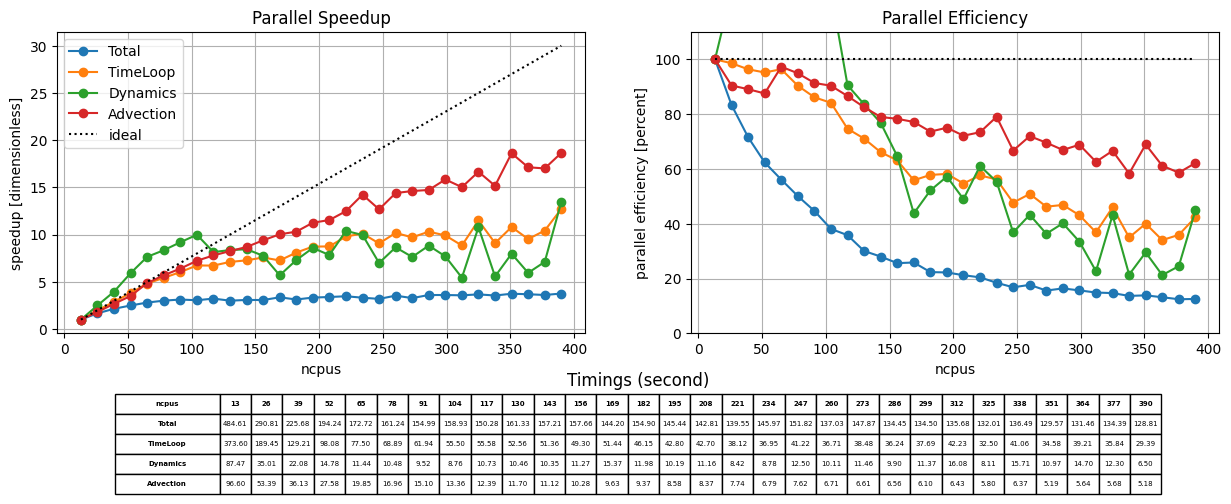

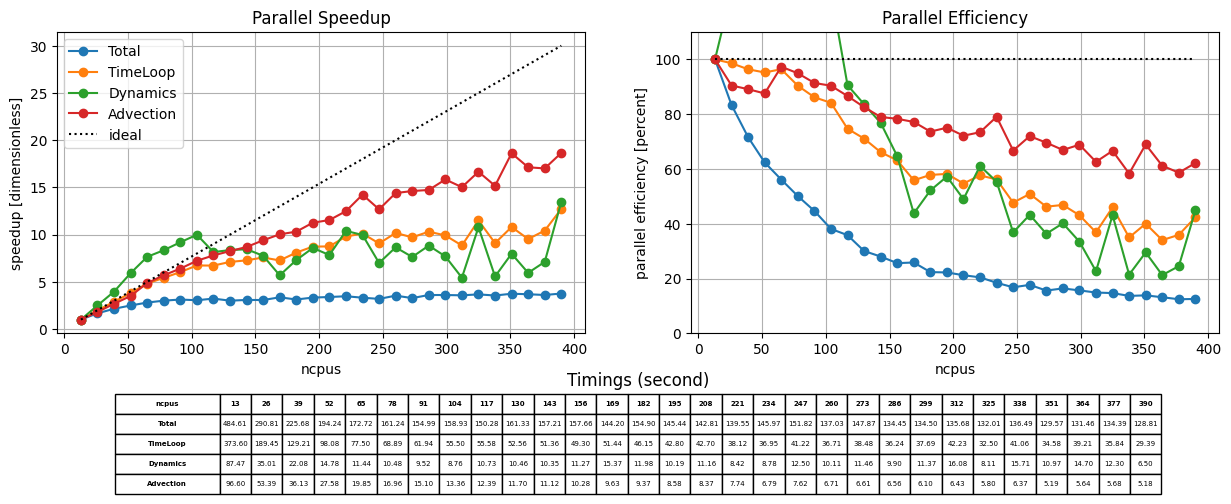

In [7]:
plot_scaling_metrics(
    stats=[cice6_stats],
    regions=[
        ["Total", "TimeLoop", "Dynamics", "Advection"], 
    ], 
    metric=tmax,
    first_col_fraction = 0.1,
)

In [8]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
!pip install pyarrow


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [9]:
def _parse_name_index(base_prefix: str, name: str):
    m = re.search(rf"{re.escape(base_prefix)}_(\d+)", name)
    case_id = int(m.group(1)) if m else None

    output_name = None
    if "/output" in name:
        output_name = name.split("/", 1)[1]  # 'output000' etc.
    elif name.endswith("_combine"):
        output_name = "combine"

    return case_id, output_name

def _build_pivot(stats_df: pd.DataFrame,
                 base_prefix: str,
                 cores: list[int],
                 ycol: str,
                 outputs: tuple[str, ...]):
    df = stats_df.copy()
    parsed = df.index.to_series().map(lambda s: _parse_name_index(base_prefix, str(s)))
    df["__case_id"] = parsed.map(lambda t: t[0])
    df["__output_name"] = parsed.map(lambda t: t[1])

    df = df[df["__output_name"].isin(outputs)].copy()
    df = df.sort_values(["__output_name", "__case_id"])

    pivot = df.pivot_table(
        index="__case_id",
        columns="__output_name",
        values=ycol,
        aggfunc="first"
    ).sort_index()

    ids_sorted = pivot.index.to_numpy()
    pivot.index = list(cores)
    pivot.index.name = "cores"
    x = pivot.index.to_numpy(dtype=float)

    return pivot, x

def _style_axes_with_top_index(ax, x: np.ndarray, *,
                               logx: bool = False, logy: bool = False,
                               xlabel: str = "Cores", top_label: str = "Index",
                               rotate: int = 45):
    if logx:
        ax.set_xscale("log")
    if logy:
        ax.set_yscale("log")

    ax.set_xticks(x)
    ax.set_xticklabels([str(int(v)) for v in x], rotation=rotate)
    ax.set_xlabel(xlabel)

    ax2 = ax.twiny()
    if logx:
        ax2.set_xscale("log")
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(x)
    ax2.set_xticklabels([str(i) for i in range(len(x))], rotation=rotate)
    ax2.set_xlabel(top_label)
    return ax2

def plot_scaling(stats_df: pd.DataFrame,
                 base_prefix: str,
                 cores: list[int],
                 ycol: str = "tmedian",
                 outputs: tuple[str, ...] = ("output000", "output001", "output002", "combine"),
                 output_for_ideal: str = "combine",
                 ideal_ref_index: int = 1,
                 title: str = "Strong scaling",
                 ylabel: str | None = None,
                 figsize: tuple[int, int] = (20, 6),
                 loglog: bool = True):
    pivot, x = _build_pivot(stats_df, base_prefix, cores, ycol, outputs)

    fig, ax = plt.subplots(figsize=figsize)
    for out in outputs:
        if out in pivot.columns:
            y = pivot[out].to_numpy(dtype=float)
            line_means, = ax.plot(x, y, "o-", linewidth=1.2, markersize=3, label=out)
            # ideal line from a chosen reference point
            if out == output_for_ideal and len(x) > ideal_ref_index:
                y0 = y[ideal_ref_index]
                x0 = x[ideal_ref_index]
                ideal = y0 * (x0 / x)
                ax.plot(x, ideal, "--", linewidth=1.0, color=line_means.get_color(), label=f"{out} (ideal)")

    _ = _style_axes_with_top_index(ax, x, logx=loglog, logy=loglog,
                                   xlabel="Cores", top_label="Index", rotate=45)

    ax.set_ylabel(ylabel or ycol)
    ax.set_title(title)
    ax.legend(ncol=3, fontsize=9)
    plt.tight_layout()
    plt.show()

    return pivot

def plot_efficiency(stats_df: pd.DataFrame,
                    base_prefix: str,
                    cores: list[int],
                    ycol: str = "tmedian",
                    outputs: tuple = ("output000", "output001", "output002", "combine"),
                    ref_output: str = "combine",
                    ref_index: int = 0,
                    title: str = "Parallel efficiency (strong scaling)",
                    ylabel: str = "Efficiency",
                    figsize: tuple = (25, 6),
                    logx: bool = False,
                    ylim: tuple | None = (0.4, 1.3)):
    pivot, x = _build_pivot(stats_df, base_prefix, cores, ycol, outputs)

    y_ref_series = pivot[ref_output].to_numpy(dtype=float)
    t_ref = y_ref_series[ref_index]
    n_ref = x[ref_index]

    fig, ax = plt.subplots(figsize=figsize)
    for xc in x:
        ax.axvline(x=xc, linestyle="-", linewidth=0.5, alpha=0.3)
    eff_cols = {}
    for out in outputs:
        if out in pivot.columns:
            y = pivot[out].to_numpy(dtype=float)
            eta = (t_ref * n_ref) / (y * x)     # strong-scaling efficiency
            ax.plot(x, eta, "o-", linewidth=1.2, markersize=3, label=out)
            eff_cols[out] = eta
    xmin, xmax = np.min(x), np.max(x)
    for level in (1.0, 0.95, 0.9, 0.8, 0.7, 0.6):
        ax.plot([xmin, xmax], [level, level], "--", linewidth=1.0, label=f"{int(level*100)}%")

    _ = _style_axes_with_top_index(ax, x, logx=logx, logy=False,
                                   xlabel="Cores", top_label="Index", rotate=45)

    if ylim is not None:
        ax.set_ylim(*ylim)

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(ncol=3, fontsize=9)
    plt.tight_layout()
    plt.show()

    eff_df = pd.DataFrame(eff_cols, index=pivot.index)
    eff_df.index.name = "cores"
    return pivot, eff_df

In [10]:
base_prefix="cice6_with_mom6_1456"
post_base_path=f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/{base_prefix}"
df = pd.read_parquet(f"{post_base_path}/cice6_json_table.parquet")
df

,hits,tmin,tmax,tavg,tmedian,tstd,pemin,pemax
name,,,,,,,,
postprocessing_cice6_with_mom6_1456_1/output000,189.0,1.480598,4.301134,1.995756,2.008976,0.194964,0,0
postprocessing_cice6_with_mom6_1456_1/output001,189.0,1.937816,4.573431,2.053235,2.039698,0.185805,0,0
postprocessing_cice6_with_mom6_1456_1/output002,189.0,1.965487,4.513989,2.079055,2.066347,0.179694,0,0
postprocessing_cice6_with_mom6_1456_1_combine,189.0,1.480598,4.573431,2.042682,2.038340,0.186821,0,0
postprocessing_cice6_with_mom6_1456_2/output000,189.0,0.702234,2.963974,0.989124,0.991853,0.153452,0,0
...,...,...,...,...,...,...,...,...
postprocessing_cice6_with_mom6_1456_29_combine,189.0,0.107245,1.458802,0.142337,0.132217,0.093196,0,0
postprocessing_cice6_with_mom6_1456_30/output000,189.0,0.071567,1.427535,0.108408,0.100524,0.096857,0,0
postprocessing_cice6_with_mom6_1456_30/output001,189.0,0.084571,1.274612,0.103651,0.095664,0.086014,0,0


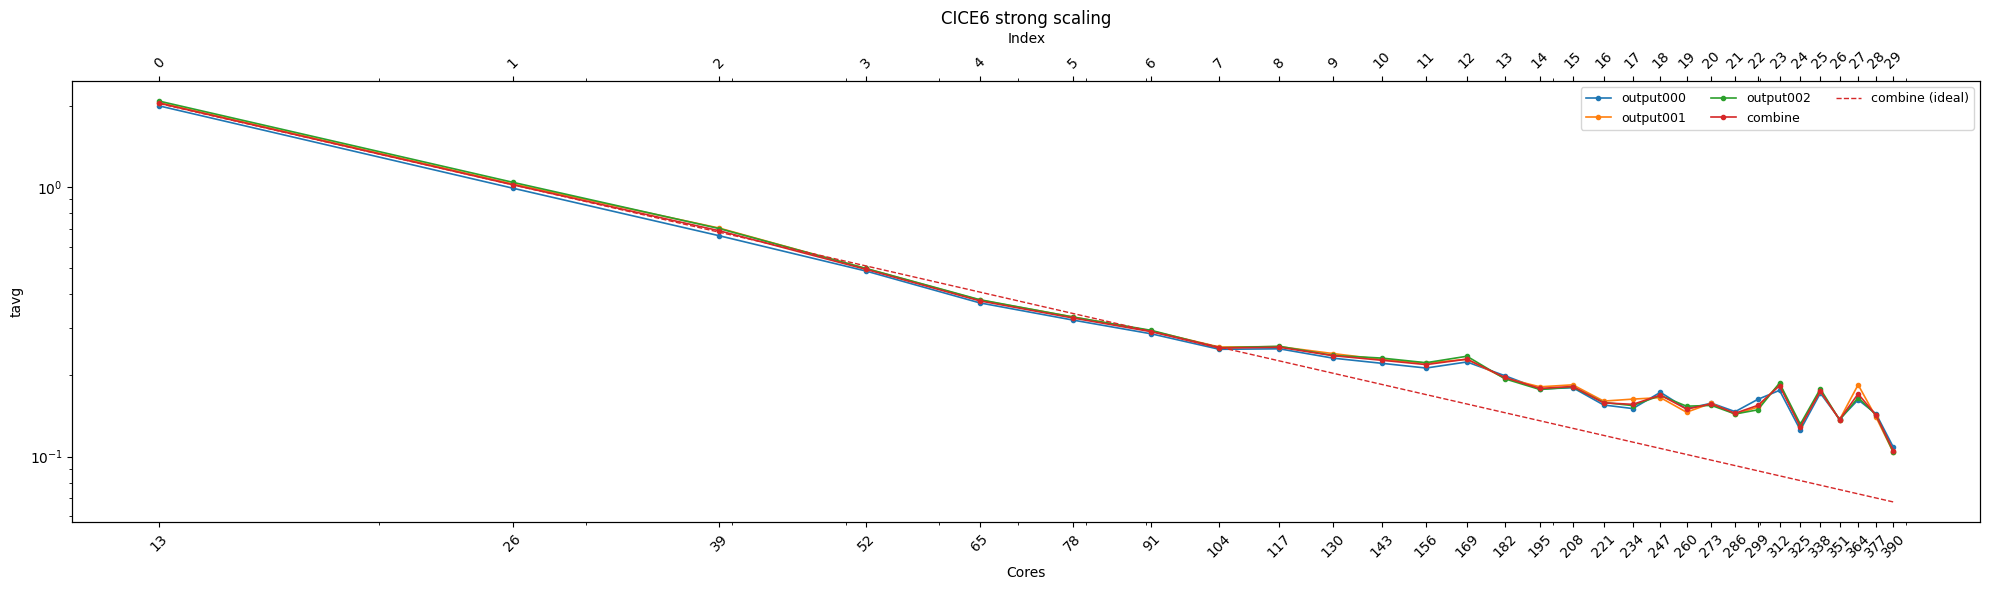

In [11]:
cores = [13, 26, 39, 52, 65, 78, 91, 104, 117, 130, 143, 156, 169, 182, 195, 208, 221, 234, 247, 260, 273, 286, 299, 312, 325, 338, 351, 364, 377, 390]
pivot = plot_scaling(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    # ycol="tmedian",
    ycol="tavg",
    outputs=("output000","output001","output002","combine"),
    output_for_ideal="combine",
    ideal_ref_index=1,
    title="CICE6 strong scaling",
)

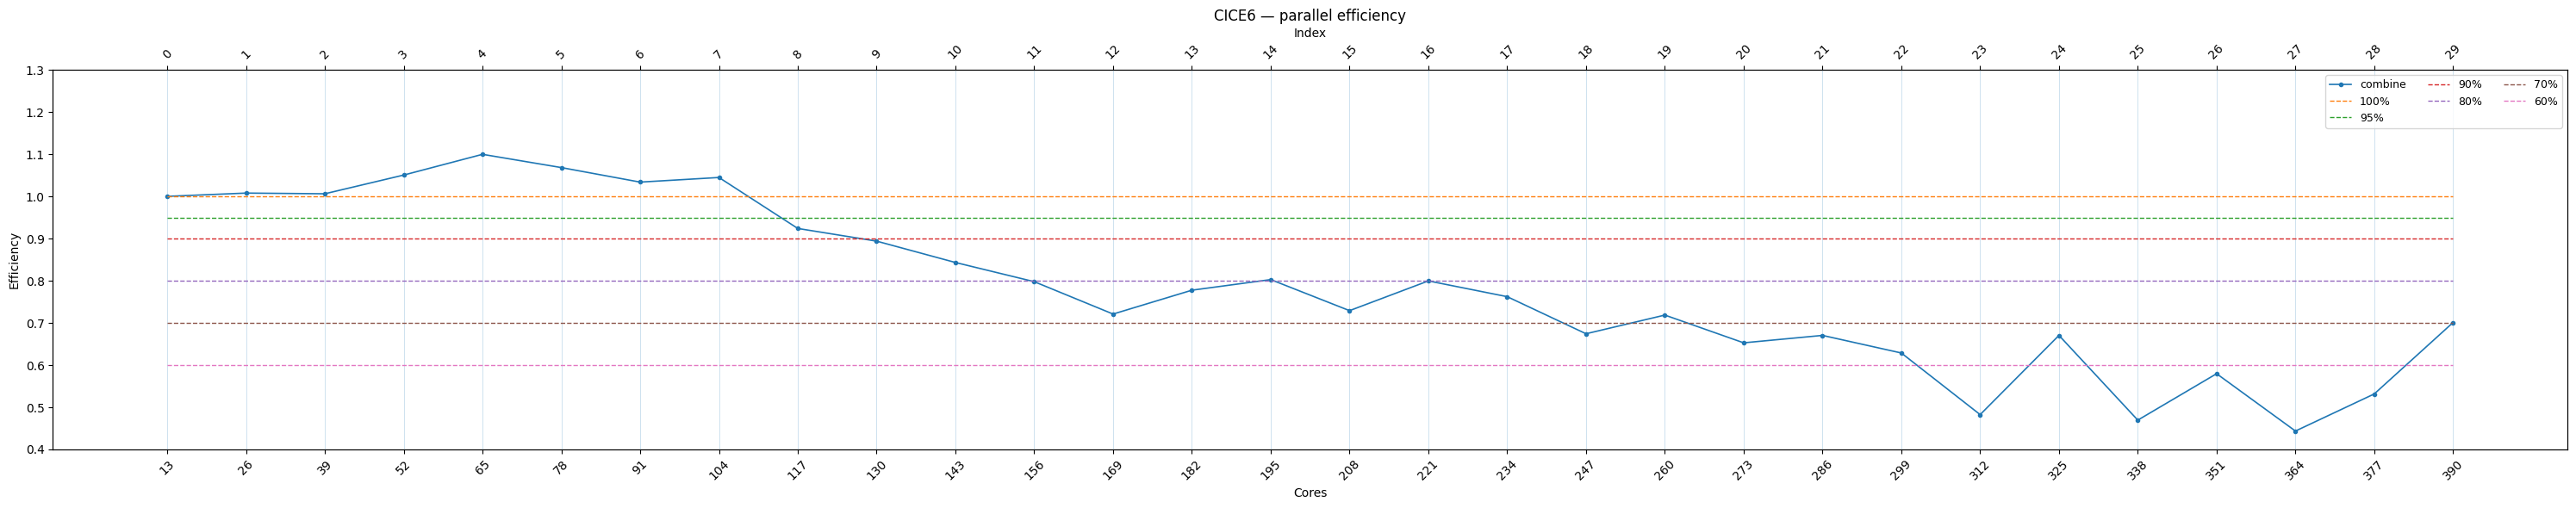

In [12]:
pivot2, eff = plot_efficiency(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    # outputs=("combine", "output000", "output001", "output002"),
    outputs=("combine",),
    ref_output="combine",
    ref_index=0,
    title="CICE6 — parallel efficiency",
    figsize=(30,6),
)

In [13]:
base_prefix="mom6"
post_base_path=f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/{base_prefix}"
df = pd.read_parquet(f"{post_base_path}/mom6_json_table.parquet")
df

,hits,tmin,tmax,tavg,tmedian,tstd,pemin,pemax
name,,,,,,,,
postprocessing_mom6_1/output000,189.0,8.882250,27.911956,11.289713,8.953883,5.637959,52,52
postprocessing_mom6_1/output001,189.0,8.857250,27.870604,11.275026,8.940505,5.639633,52,52
postprocessing_mom6_1/output002,189.0,8.885236,28.076329,11.313489,8.963507,5.679227,52,52
postprocessing_mom6_1_combine,189.0,8.857250,28.076329,11.292743,8.952632,5.652273,52,52
postprocessing_mom6_2/output000,189.0,4.797043,14.838964,6.049677,4.838296,2.896648,52,52
...,...,...,...,...,...,...,...,...
postprocessing_mom6_49_combine,189.0,0.250181,1.153262,0.342180,0.283068,0.156446,52,52
postprocessing_mom6_50/output000,189.0,0.249485,1.167519,0.334624,0.274225,0.156513,52,52
postprocessing_mom6_50/output001,189.0,0.249855,1.161537,0.337742,0.278114,0.156761,52,52


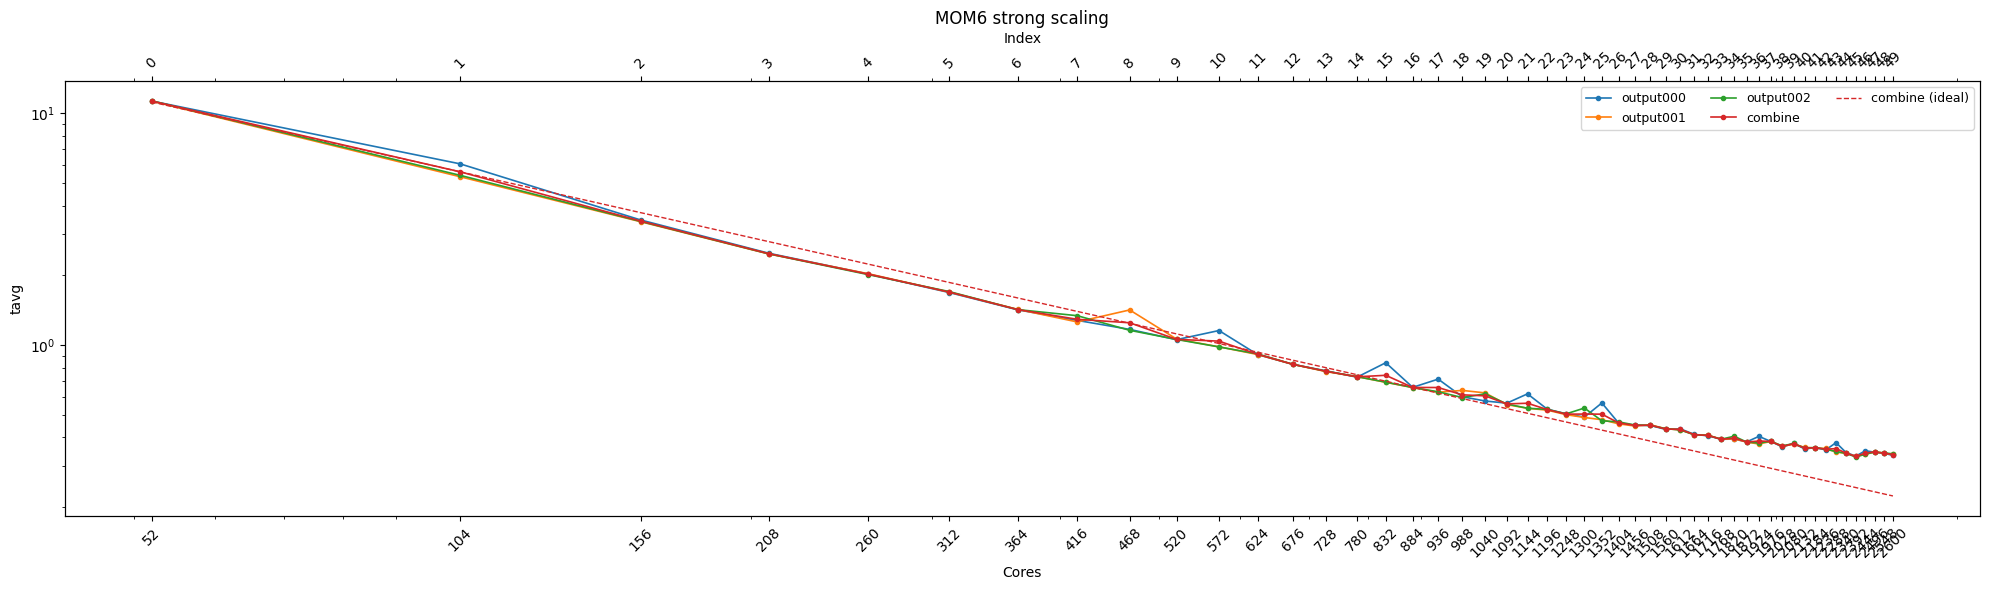

In [14]:
cores = [52, 104, 156, 208, 260, 312, 364, 416, 468, 520, 572, 624, 676, 728, 780, 832, 884, 936, 988, 1040, 1092, 1144, 1196, 1248, 1300, 1352, 1404, 1456, 1508, 1560, 1612, 1664, 1716, 1768, 1820, 1872, 1924, 1976, 2028, 2080, 2132, 2184, 2236, 2288, 2340, 2392, 2444, 2496, 2548, 2600]
pivot = plot_scaling(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    # ycol="tmedian",
    ycol="tavg",
    outputs=("output000","output001","output002","combine"),
    output_for_ideal="combine",
    ideal_ref_index=1,
    title="MOM6 strong scaling",
)

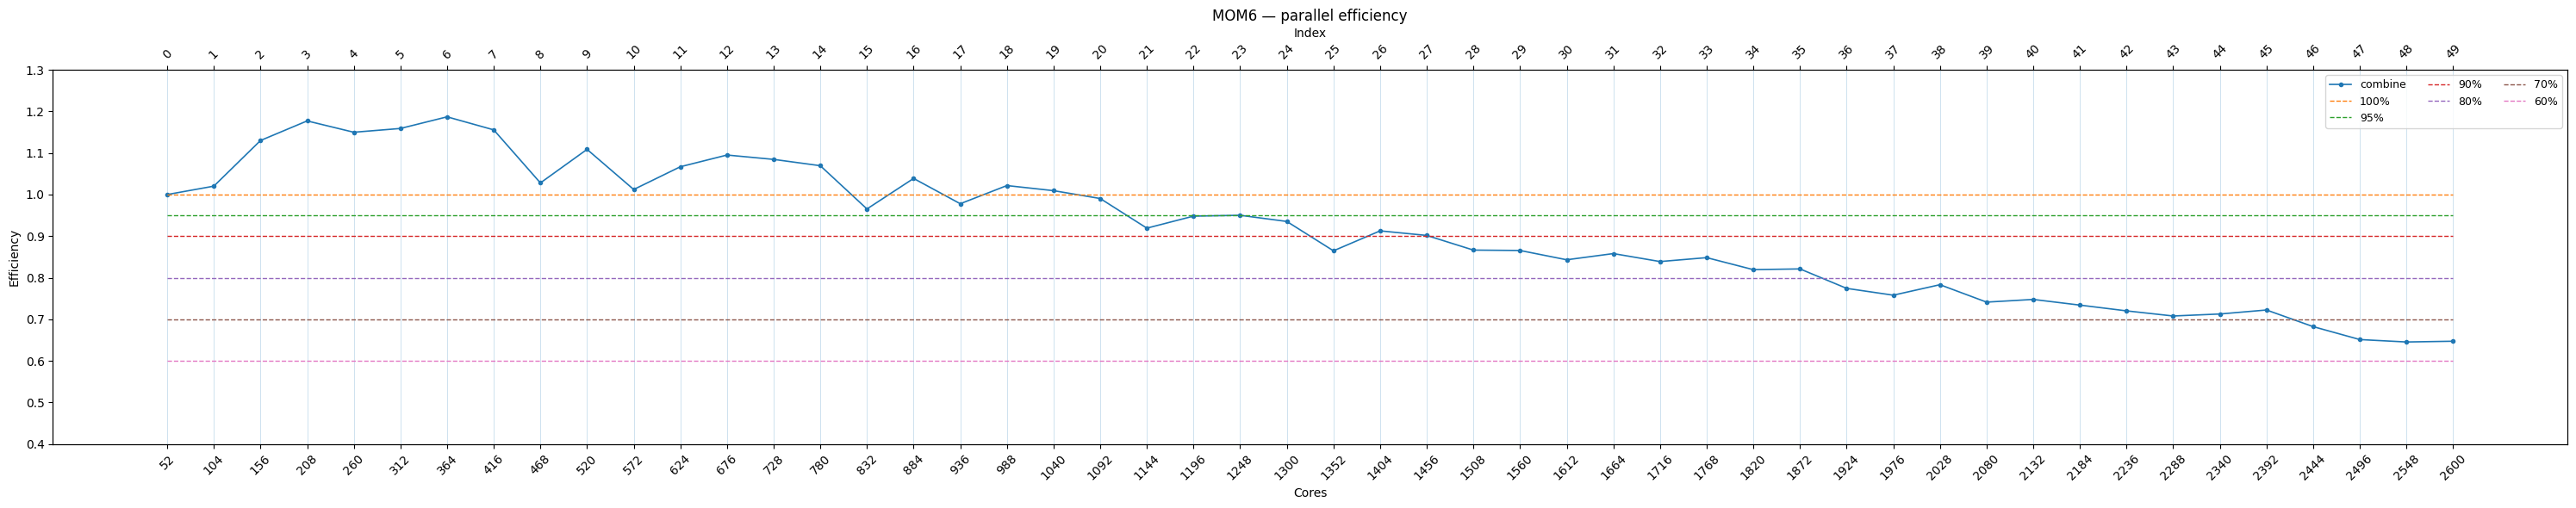

In [15]:
pivot2, eff = plot_efficiency(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    # outputs=("combine", "output000", "output001", "output002"),
    outputs=("combine",),
    ref_output="combine",
    ref_index=0,
    title="MOM6 — parallel efficiency",
    figsize=(30,6),
)